## Example Analysis: Face and Hand Detection

This brief tutorial will demonstrate face and hand detection using [Google's Mediapipe tool](https://ai.google.dev/edge/mediapipe/solutions/guide). We will use a single video as an example.

We will first import the necessary Python libraries.

In [17]:
!pip install protobuf==4.25.3
!pip install mediapipe==0.10.14

import cv2
import mediapipe as mp
import os
import numpy as np
import pandas as pd
import yaml

For this tutorial, we have uploaded the relevant files directly to the notebook. The session we are using is:
2023_08_22_17_37_35

If you are running a similar analysis on your local computer, we recommend setting a origin path to all session folders:

```
origin_path = '/path/to/session/folders/
```
From there, you can easily create a list of sessions:


```
dirs = [x[0] for x in os.walk(origin_path)]
```

We will next set up our face and hand detection models in Mediapipe.



In [2]:
origin = '/content/drive/MyDrive/Research/VEDB/2023_08_22_17_37_35'

In [3]:
# Face detection module
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Hand detection module
mp_hands = mp.solutions.hands
hand_detection = mp_hands.Hands()

Our output will be two heatmaps: one for face locations and one for hand locations. We will create numpy arrays to store these, based on the dimensions of the 3.1 MP world camera.

In [4]:
face_heatmap = np.zeros((1536, 2048))
hand_heatmap = np.zeros((1536, 2048))

Let's now open the world camera video and compute some basic statistics about this session.

Please note that we are releasing a slightly modified video that has already detected and blurred faces for privacy purposes.

In [5]:
# create the video object
vid = cv2.VideoCapture(os.path.join(origin, 'world.mp4'))

# compute total number of frames
vid_length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

# get the frame rate of the video
fps = vid.get(cv2.CAP_PROP_FPS)

# get the total video time
video_time_length = round(vid_length / fps)

# print the result
print('This video is {} seconds long, with {} frames at {} frames per second'.format(video_time_length, vid_length, fps))

This video is 1685 seconds long, with 50561 frames at 30.0 frames per second


For each session, there is a marker_times.yaml file that provides the minute and second stamps for eye tracking calibration and validation. For this analysis, we'll only consider the video frames after calibration and validation since hands will be in unusual locations during the calibration/validation procedure.

For now, we'll read in the marker file.

In [6]:
with open(os.path.join(origin, 'marker_times.yaml'), 'r') as file:
    marker_times = yaml.safe_load(file)

# parse validation end frames
validation_end_frame = marker_times["validation_frames"][0][1]

With this in place, we're ready for the main loop. This segment will examine the video frame by frame, starting from the end of the validation session. In each frame, the Mediapipe hand and face detectors will be applied. If a face or hand is detected, the bounding box will be added to the respective heatmap.

In [7]:
frame_count = 0

while vid.isOpened():
    # read a frame
    success, image = vid.read()

    # assume that lack of success is the end of the video
    if not success:
        break

    # increment frame counter
    frame_count += 1

    # print progress every 100 frames
    if frame_count%100 == 0:
      proportion = round((frame_count / vid_length) * 100, 2)  # Round to 2 decimal places
      print('Processed {}% of video'.format(proportion))

    # pass over frame if it is before the end of validation
    # takes one frame per second for efficiency
    if frame_count > validation_end_frame and frame_count % int(fps) == 0:
        # convert frame to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # apply face detector
        face_result = face_detection.process(image[:,:,::-1])

        # loop through each face and add bounding box to heatmap
        if face_result.detections:
          for detection in face_result.detections:
            # get the bounding box
            bboxC = detection.location_data.relative_bounding_box

            # get the coordinates of the bounding box
            x, y, w, h = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
              int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])

            # update the face heatmap
            face_heatmap[y:y+h, x:x+w] += 1

        # apply the hand detector
        hand_result = hand_detection.process(image)

        # loop through each hand and add bounding box to heatmap
        if hand_result.multi_hand_landmarks:
          for hand_landmarks in hand_result.multi_hand_landmarks:
            # establish image boundaries
            x_max = 0
            y_max = 0
            x_min = image.shape[1]
            y_min = image.shape[0]

            for lm in hand_landmarks.landmark:
              # get vertices for hand
              x,y = int(lm.x * image.shape[1]), int(lm.y * image.shape[0])

              # find bounding box from vertices
              x_min, x_max = min(x, x_min), max(x, x_max)
              y_min, y_max = min(y, y_min), max(y, y_max)

              # update the heatmap
              hand_heatmap[y_min:y_max, x_min:x_max] += 1


Processed 0.2% of video
Processed 0.4% of video
Processed 0.59% of video
Processed 0.79% of video
Processed 0.99% of video
Processed 1.19% of video
Processed 1.38% of video
Processed 1.58% of video
Processed 1.78% of video
Processed 1.98% of video
Processed 2.18% of video
Processed 2.37% of video
Processed 2.57% of video
Processed 2.77% of video
Processed 2.97% of video
Processed 3.16% of video
Processed 3.36% of video
Processed 3.56% of video
Processed 3.76% of video
Processed 3.96% of video
Processed 4.15% of video
Processed 4.35% of video
Processed 4.55% of video
Processed 4.75% of video
Processed 4.94% of video
Processed 5.14% of video
Processed 5.34% of video
Processed 5.54% of video
Processed 5.74% of video
Processed 5.93% of video
Processed 6.13% of video
Processed 6.33% of video
Processed 6.53% of video
Processed 6.72% of video


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processed 6.92% of video
Processed 7.12% of video
Processed 7.32% of video
Processed 7.52% of video
Processed 7.71% of video
Processed 7.91% of video
Processed 8.11% of video
Processed 8.31% of video
Processed 8.5% of video
Processed 8.7% of video
Processed 8.9% of video
Processed 9.1% of video
Processed 9.3% of video
Processed 9.49% of video
Processed 9.69% of video
Processed 9.89% of video
Processed 10.09% of video
Processed 10.28% of video
Processed 10.48% of video
Processed 10.68% of video
Processed 10.88% of video
Processed 11.08% of video
Processed 11.27% of video
Processed 11.47% of video
Processed 11.67% of video
Processed 11.87% of video
Processed 12.06% of video
Processed 12.26% of video
Processed 12.46% of video
Processed 12.66% of video
Processed 12.86% of video
Processed 13.05% of video
Processed 13.25% of video
Processed 13.45% of video
Processed 13.65% of video
Processed 13.84% of video
Processed 14.04% of video
Processed 14.24% of video
Processed 14.44% of video
Process

Now let's display the results!

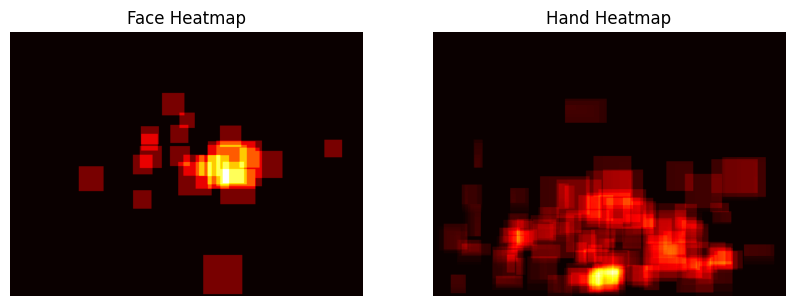

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax[0].imshow(face_heatmap, cmap='hot')
ax[0].axis('off')
ax[0].set_title('Face Heatmap')

ax[1].imshow(hand_heatmap, cmap='hot')
ax[1].axis('off')
ax[1].set_title('Hand Heatmap')

plt.show()

##Example Analysis: Fixating faces and hands

Let's now incorporate the gaze data into this analysis and compute the probability of fixating on a hand or face.

The [OSF directory](https://osf.io/2gdkb/) contains the processed gaze files. In a complete session, nine files will be present. Of these, *gaze.npz* contains the processed gaze data. Let's read this in.



In [11]:
gaze_file_path = os.path.join(origin, 'processedGaze', 'gaze.npz')
gaze = dict(np.load(gaze_file_path, allow_pickle=True))

# split right and left eyes
gaze_right, gaze_left = gaze['right'].flatten()[0], gaze['left'].flatten()[0]

For this analysis, we will use monocular gaze tracking. We will select the eye with the highest pupil detection confidence, on average.

In [12]:
left_conf = gaze_left['confidence']
right_conf = gaze_right['confidence']

if np.mean(left_conf) > np.mean(right_conf):
    good_eye = gaze_left
    conf = left_conf
else:
    good_eye = gaze_right
    conf = right_conf

print('Left eye: {}; Right eye: {}'.format(np.mean(left_conf), np.mean(right_conf)))

Left eye: 0.7076662711501498; Right eye: 0.7553478613403534


Now, we're ready to use these gaze data. Here are some counters to keep track of the number of frames with faces and hands, and the number of times a face or hand was fixated. We'll also code in the size of the image frame.

In [13]:
face_frame_count = 0
hand_frame_count = 0
face_fixation_count = 0
hand_fixation_count = 0

full_frame_size = np.array([2048, 1536])

We'll take the same loop that we used above and modify it to use gaze data.

In [16]:
# create the video object
vid = cv2.VideoCapture(os.path.join(origin, 'world.mp4'))

frame_count = 0

while vid.isOpened():
    # read a frame
    success, image = vid.read()

    # assume that lack of success is the end of the video
    if not success:
        break

    # increment frame counter
    frame_count += 1

    # print progress every 100 frames
    if frame_count%100 == 0:
      proportion = round((frame_count / vid_length) * 100, 2)  # Round to 2 decimal places
      print('Processed {}% of video'.format(proportion))

    # pass over frame if it is before the end of validation
    # takes one frame per second for efficiency
    if frame_count > validation_end_frame and frame_count % int(fps) == 0:
        # convert frame to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # get the relevant range of gaze data, given 120 Hz eye cameras
        eye_frames = np.arange(frame_count, frame_count+4) * 4

        # remove low-confidence frames
        eye_frames = eye_frames[conf[eye_frames]>0.4]

        # get the gaze location of the relevant frames
        positions = good_eye['norm_pos'][eye_frames,:]

        # compute the median location
        median_position = np.median(positions, axis=0)

        # convert to image coordinates
        gaze_pos = np.round(np.multiply(median_position, full_frame_size)).astype(int)

        # apply face detector
        face_result = face_detection.process(image[:,:,::-1])

        # loop through each face and add bounding box to heatmap
        if face_result.detections:
          face_frame_count += 1

          for detection in face_result.detections:
            # get the bounding box
            bboxC = detection.location_data.relative_bounding_box

            # get the coordinates of the bounding box
            x, y, w, h = int(bboxC.xmin * image.shape[1]), int(bboxC.ymin * image.shape[0]), \
              int(bboxC.width * image.shape[1]), int(bboxC.height * image.shape[0])

            # check if gaze_pos is inside the bounding box
            if x <= gaze_pos[0] <= x+w and y <= gaze_pos[1] <= y+h:
              face_fixation_count += 1

        # apply the hand detector
        hand_result = hand_detection.process(image)

        # loop through each hand and add bounding box to heatmap
        if hand_result.multi_hand_landmarks:
          hand_frame_count += 1

          for hand_landmarks in hand_result.multi_hand_landmarks:
            # establish image boundaries
            x_max = 0
            y_max = 0
            x_min = image.shape[1]
            y_min = image.shape[0]

            for lm in hand_landmarks.landmark:
              # get vertices for hand
              x,y = int(lm.x * image.shape[1]), int(lm.y * image.shape[0])

              # find bounding box from vertices
              x_min, x_max = min(x, x_min), max(x, x_max)
              y_min, y_max = min(y, y_min), max(y, y_max)

              # check if gaze is inside bounding box
              if x_min <= gaze_pos[0] <= x_max and y_min <= gaze_pos[1] <= y_max:
                hand_fixation_count += 1

# Print the final results
print('This video had {} frames with faces, of which {} were fixated. ({}%)'.format(face_frame_count, face_fixation_count, round(face_fixation_count/face_frame_count*100, 2)))
print('This video had {} frames with hands, of which {} were fixated. ({}%)'.format(hand_frame_count, hand_fixation_count, round(hand_fixation_count/hand_frame_count*100, 2)))

Processed 0.2% of video
Processed 0.4% of video
Processed 0.59% of video
Processed 0.79% of video
Processed 0.99% of video
Processed 1.19% of video
Processed 1.38% of video
Processed 1.58% of video
Processed 1.78% of video
Processed 1.98% of video
Processed 2.18% of video
Processed 2.37% of video
Processed 2.57% of video
Processed 2.77% of video
Processed 2.97% of video
Processed 3.16% of video
Processed 3.36% of video
Processed 3.56% of video
Processed 3.76% of video
Processed 3.96% of video
Processed 4.15% of video
Processed 4.35% of video
Processed 4.55% of video
Processed 4.75% of video
Processed 4.94% of video
Processed 5.14% of video
Processed 5.34% of video
Processed 5.54% of video
Processed 5.74% of video
Processed 5.93% of video
Processed 6.13% of video
Processed 6.33% of video
Processed 6.53% of video
Processed 6.72% of video


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processed 6.92% of video
Processed 7.12% of video
Processed 7.32% of video
Processed 7.52% of video
Processed 7.71% of video
Processed 7.91% of video
Processed 8.11% of video
Processed 8.31% of video
Processed 8.5% of video
Processed 8.7% of video
Processed 8.9% of video
Processed 9.1% of video
Processed 9.3% of video
Processed 9.49% of video
Processed 9.69% of video
Processed 9.89% of video
Processed 10.09% of video
Processed 10.28% of video
Processed 10.48% of video
Processed 10.68% of video
Processed 10.88% of video
Processed 11.08% of video
Processed 11.27% of video
Processed 11.47% of video
Processed 11.67% of video
Processed 11.87% of video
Processed 12.06% of video
Processed 12.26% of video
Processed 12.46% of video
Processed 12.66% of video
Processed 12.86% of video
Processed 13.05% of video
Processed 13.25% of video
Processed 13.45% of video
Processed 13.65% of video
Processed 13.84% of video
Processed 14.04% of video
Processed 14.24% of video
Processed 14.44% of video
Process

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
<ipython-input-16-c848425dbfa3>:41: RuntimeWarning: invalid value encountered in cast
  gaze_pos = np.round(np.multiply(median_position, full_frame_size)).astype(int)


Processed 35.2% of video
Processed 35.4% of video
Processed 35.6% of video
Processed 35.8% of video
Processed 36.0% of video
Processed 36.19% of video
Processed 36.39% of video
Processed 36.59% of video
Processed 36.79% of video
Processed 36.99% of video
Processed 37.18% of video
Processed 37.38% of video
Processed 37.58% of video
Processed 37.78% of video
Processed 37.97% of video
Processed 38.17% of video
Processed 38.37% of video
Processed 38.57% of video
Processed 38.77% of video
Processed 38.96% of video
Processed 39.16% of video
Processed 39.36% of video
Processed 39.56% of video
Processed 39.75% of video
Processed 39.95% of video
Processed 40.15% of video
Processed 40.35% of video
Processed 40.55% of video
Processed 40.74% of video
Processed 40.94% of video
Processed 41.14% of video
Processed 41.34% of video
Processed 41.53% of video
Processed 41.73% of video
Processed 41.93% of video
Processed 42.13% of video
Processed 42.33% of video
Processed 42.52% of video
Processed 42.72% 